In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten
from keras import backend as K
from keras.layers.recurrent import GRU

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
import glob

img_path = 'words/a01/a01-000u/*'

sentences = []
with open('words.txt','r') as f:
    while True:
        line = f.readline().strip().replace('\'','').replace('\"','') 
        if line == '':
            break
        if line[0]!='#':
            sentences.append(line.split(' '))


In [7]:
import csv
df = pd.DataFrame(sentences)
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A,None,None
1,a01-000u-00-01,ok,154,507,766,213,48,NN,MOVE,None,None
2,a01-000u-00-02,ok,154,796,764,70,50,TO,to,None,None


(51, 27)


0    A
Name: 8, dtype: object

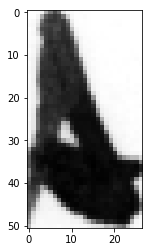

In [8]:
import cv2

img = cv2.imread(glob.glob(img_path)[0], cv2.IMREAD_GRAYSCALE)
print(img.shape)

plt.imshow(img, cmap='Greys_r')
                 
df[8].head(1)

In [15]:
# top_paths = 3
# results = []
# for i in range(top_paths):
#   lables = K.get_value(K.ctc_decode(out, input_length=np.ones(out.shape[0])*out.shape[1],
#                        greedy=False, beam_width=top_paths, top_paths=top_paths)[0][i])[0]
#   results.append(lables)

In [13]:
# run_name, start_epoch, stop_epoch, img_w
# Input Parameters
img_h = 64
words_per_epoch = 16000
val_split = 0.2
val_words = int(words_per_epoch * (val_split))

In [14]:
# Network parameters
conv_filters = 16
kernel_size = (3, 3)
pool_size = 2
time_dense_size = 32
rnn_size = 512
minibatch_size = 32

In [16]:
if K.image_data_format() == 'channels_first':
    input_shape = (1, img_w, img_h)
else:
    input_shape = (img_w, img_h, 1)

fdir = os.path.dirname(
    get_file('wordlists.tgz',
             origin='http://www.mythic-ai.com/datasets/wordlists.tgz',
             untar=True))

NameError: name 'img_w' is not defined

In [ ]:
img_gen = TextImageGenerator(
    monogram_file=os.path.join(fdir, 'wordlist_mono_clean.txt'),
    bigram_file=os.path.join(fdir, 'wordlist_bi_clean.txt'),
    minibatch_size=minibatch_size,
    img_w=img_w,
    img_h=img_h,
    downsample_factor=(pool_size ** 2),
    val_split=words_per_epoch - val_words)
act = 'relu'
input_data = Input(name='the_input', shape=input_shape, dtype='float32')
inner = Conv2D(conv_filters, kernel_size, padding='same',
               activation=act, kernel_initializer='he_normal',
               name='conv1')(input_data)
inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
inner = Conv2D(conv_filters, kernel_size, padding='same',
               activation=act, kernel_initializer='he_normal',
               name='conv2')(inner)
inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)

conv_to_rnn_dims = (img_w // (pool_size ** 2),
                    (img_h // (pool_size ** 2)) * conv_filters)
inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

# cuts down input size going into RNN:
inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

# Two layers of bidirectional GRUs
# GRU seems to work as well, if not better than LSTM:
gru_1 = GRU(rnn_size, return_sequences=True,
            kernel_initializer='he_normal', name='gru1')(inner)
gru_1b = GRU(rnn_size, return_sequences=True,
             go_backwards=True, kernel_initializer='he_normal',
             name='gru1_b')(inner)
gru1_merged = add([gru_1, gru_1b])
gru_2 = GRU(rnn_size, return_sequences=True,
            kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True,
             kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

# transforms RNN output to character activations:
inner = Dense(img_gen.get_output_size(), kernel_initializer='he_normal',
              name='dense2')(concatenate([gru_2, gru_2b]))
y_pred = Activation('softmax', name='softmax')(inner)
Model(inputs=input_data, outputs=y_pred).summary()

labels = Input(name='the_labels',
               shape=[img_gen.absolute_max_string_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
# Keras doesn't currently support loss funcs with extra parameters
# so CTC loss is implemented in a lambda layer
loss_out = Lambda(
    ctc_lambda_func, output_shape=(1,),
    name='ctc')([y_pred, labels, input_length, label_length])

# clipnorm seems to speeds up convergence
sgd = SGD(learning_rate=0.02,
          decay=1e-6,
          momentum=0.9,
          nesterov=True)

model = Model(inputs=[input_data, labels, input_length, label_length],
              outputs=loss_out)

In [ ]:
# the loss calc occurs elsewhere, so use a dummy lambda func for the loss
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)

In [ ]:
if start_epoch > 0:
    weight_file = os.path.join(
        OUTPUT_DIR,
        os.path.join(run_name, 'weights%02d.h5' % (start_epoch - 1)))
    model.load_weights(weight_file)

In [ ]:
# captures output of softmax so we can decode the output during visualization
test_func = K.function([input_data], [y_pred])

In [ ]:
viz_cb = VizCallback(run_name, test_func, img_gen.next_val())

In [11]:
model.fit_generator(
    generator=img_gen.next_train(),
    steps_per_epoch=(words_per_epoch - val_words) // minibatch_size,
    epochs=stop_epoch,
    validation_data=img_gen.next_val(),
    validation_steps=val_words // minibatch_size,
    callbacks=[viz_cb, img_gen],
    initial_epoch=start_epoch)